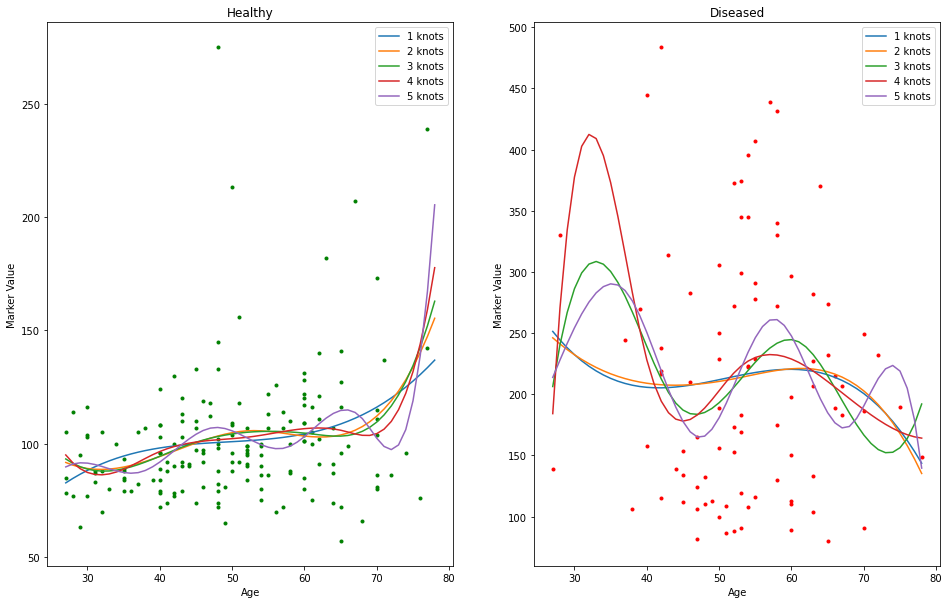

In [1]:
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpol
from statsmodels.distributions.empirical_distribution import ECDF

diabetes_data = np.loadtxt('C:/Mark/uni/Uni Work/5th Year/Diss/Coding ROC Curves in Python Diabetes/DiabetesData.csv',
                       dtype=float,
                       delimiter=',',
                       skiprows=1)

# Pick out diseased and healthy
yh = diabetes_data[diabetes_data[:,1] == 0]
yd = diabetes_data[diabetes_data[:,1] == 1]

# Sort the data by age 
yh = yh[yh[:, 2].argsort()]
yd = yd[yd[:, 2].argsort()]

yh = yh[yh[:,2] >= 27]
yh = yh[yh[:,2] <= 78]

yd = yd[yd[:,2] >= 27]
yd = yd[yd[:,2] <= 78]

# Pick out only the marker values
yh_val = yh[:, 0]
yd_val = yd[:, 0]

# Pick out only the ages
xh = yh[:, 2]
xd = yd[:, 2]

age_grid = np.linspace(27, 78, 78-27+1)

fig, ax = plt.subplots(1,2, figsize=(16,10))

ax[0].plot(xh, yh_val, 'g.')
ax[0].set_title('Healthy')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Marker Value')


ax[1].plot(xd, yd_val, 'r.')
ax[1].set_title('Diseased')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Marker Value')

numknots = 3

for i in range(1,6):
    t, c, k = interpol.splrep(xh, yh_val, k=3, t=np.quantile(age_grid, np.linspace(0,1,i,endpoint=False)[1:]), task=-1)
    x_bs = interpol.BSpline(t, c, k)
    y_bs = [x_bs(i) for i in age_grid]
    ax[0].plot(age_grid, y_bs, label=f'{i} knots')
    
for i in range(1,6):
    t, c, k = interpol.splrep(xd, yd_val, k=3, t=np.quantile(age_grid, np.linspace(0,1,i,endpoint=False)[1:]), task=-1)
    x_bs = interpol.BSpline(t, c, k)
    y_bs = [x_bs(i) for i in age_grid]
    ax[1].plot(age_grid, y_bs,label=f'{i} knots')
    
for i in ax:
    i.legend()

plt.show()

[27. 27. 27. 27. 44. 61. 77. 77. 77. 77.] [ 93.22464652  80.7249142  105.52191059 106.81130781  98.02139477
 151.99198536   0.           0.           0.           0.        ] 3


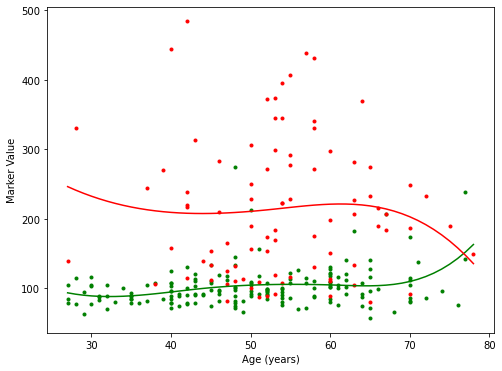

In [2]:
plt.figure(figsize=(8,6))
plt.plot(xh, yh_val, 'g.', label='healthy')
plt.plot(xd, yd_val, 'r.', label='diseased')

age_grid = np.linspace(27, 78, 78-27+1)

th, ch, kh = interpol.splrep(xh, yh_val, k=3, t=np.quantile(age_grid, np.linspace(0,1,3,endpoint=False)[1:]), task=-1)
bs_h = interpol.BSpline(th, ch, kh)
y_bs_h = [bs_h(i) for i in age_grid]
print(th, ch, kh)

t, c, k = interpol.splrep(xd, yd_val, k=3, t=np.quantile(age_grid, np.linspace(0, 1, 2,endpoint=False)[1:]), task=-1)
bs_d = interpol.BSpline(t, c, k)
y_bs_d = [bs_d(i) for i in age_grid]

plt.plot(age_grid, y_bs_h, 'g')
plt.plot(age_grid, y_bs_d, 'r')
plt.xlabel('Age (years)')
plt.ylabel('Marker Value')
plt.show()

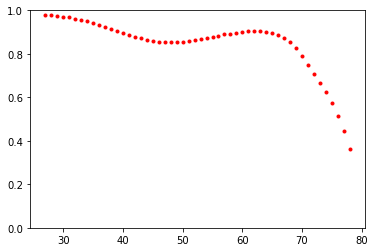

In [3]:
plt.figure()

# Calculate sigma hat
yh_hat = bs_h(xh)
residualsh = yh_val - yh_hat
residual_sum_of_squaresh = residualsh.T @ residualsh
sigmah = np.sqrt(residual_sum_of_squaresh/(len(yh_val)-2))

# Calculate sigma hat
yd_hat = bs_d(xd)
residualsd = yd_val - yd_hat
residual_sum_of_squaresd = residualsd.T @ residualsd
sigmad = np.sqrt(residual_sum_of_squaresd/(len(yd_val)-2))

p = np.linspace(0,1,101)
muh_pred = np.array([bs_h(i) for i in age_grid])
mud_pred = np.array([bs_d(i) for i in age_grid])

roc_age_est_full_data = []
auc_age_est_full_data2 = []

F_emp_D = ECDF(residualsd/sigmad)

for i in range(len(age_grid)):
    a = (mud_pred[i] - muh_pred[i]) / sigmad
    b = sigmah / sigmad
    
    roc_now_full_data = 1-F_emp_D(-a + b*np.quantile(residualsh/sigmah, q=1-p))
    auc_now_full_data = np.sum(roc_now_full_data)/len(roc_now_full_data)       # roc_now: AUC as average TPF over all FPFs
    
    roc_age_est_full_data.append(roc_now_full_data)
    auc_age_est_full_data2.append(auc_now_full_data)
 
auc_age_est_full_data = np.array(auc_age_est_full_data2)
roc_age_est_full_data = np.array(roc_age_est_full_data)

plt.plot(age_grid, auc_age_est_full_data2, 'r.')


plt.ylim(0,1)

plt.show()

# plt.figure()

# plt.plot(age_grid[0], muh_pred[0],'.')
# plt.plot(age_grid[0], mud_pred[0],'.')

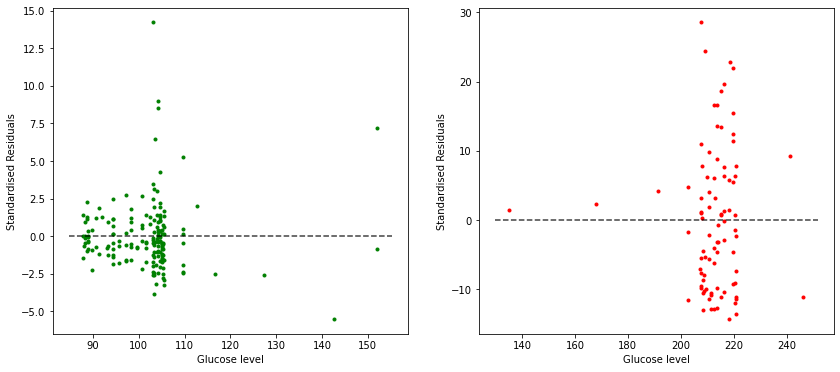

In [6]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].set_xlabel('Glucose level')
ax[0].set_ylabel('Standardised Residuals')
ax[0].plot(bs_h(xh),residualsh/np.std(xh), 'g.')

ax[1].set_xlabel('Glucose level')
ax[1].set_ylabel('Standardised Residuals')
ax[1].plot(bs_d(xd),residualsd/np.std(xd), 'r.')

for i in ax:
    minx, maxx = i.get_xlim()
    i.plot([minx,maxx],np.zeros(2), 'k--', alpha=0.75)

(0.0, 1.0)

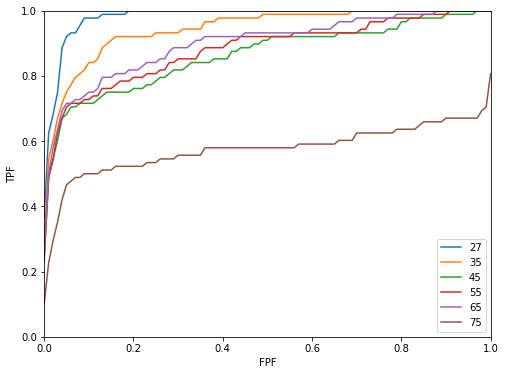

In [128]:
plt.figure(figsize = (8,6))
plt.plot(p, roc_age_est_full_data[0,:], label = "27")
plt.plot(p, roc_age_est_full_data[8,:], label = "35")
plt.plot(p, roc_age_est_full_data[18,:], label = "45")
plt.plot(p, roc_age_est_full_data[28,:], label = "55")
plt.plot(p, roc_age_est_full_data[38,:], label = "65")
plt.plot(p, roc_age_est_full_data[48,:], label = "75")
plt.legend()
plt.xlabel('FPF')
plt.ylabel('TPF')
plt.ylim(0,1)
plt.xlim(0,1)

# Bootstrap

In [129]:
diabetes_data = np.loadtxt('C:/Mark/uni/Uni Work/5th Year/Diss/Coding ROC Curves in Python Diabetes/DiabetesData.csv',
                       dtype=float,
                       delimiter=',',
                       skiprows=1)

age_grid = np.linspace(27, 78, 78-27+1)

"""
Bootstrapping Below
"""
AUCs = []
ROCs = []

for _ in range(1000):
    # Pick out diseased and healthy
    data_len = len(diabetes_data)
    random_data = np.array([diabetes_data[random.randint(0, data_len-1)] for _ in range(data_len)])
    
    # Pick out diseased and healthy
    yh = random_data[random_data[:,1] == 0]
    yd = random_data[random_data[:,1] == 1]

    # Sort the data by age 
    yh = yh[yh[:, 2].argsort()]
    yd = yd[yd[:, 2].argsort()]
    
    yh = yh[yh[:,2] >= 27]
    yh = yh[yh[:,2] <= 78]
    
    yd = yd[yd[:,2] >= 27]
    yd = yd[yd[:,2] <= 78]

    # Pick out only the marker values
    yh_val = yh[:, 0]
    yd_val = yd[:, 0]

    # Pick out only the ages
    xh = yh[:, 2]
    xd = yd[:, 2]
    
    # Make the age grid
    age_grid = age_grid = np.linspace(27, 78, 78-27+1)

    # Fit the healthy B-Spline model with 4 knots
    th, ch, kh = interpol.splrep(xh, yh_val, k=3, t=np.quantile(age_grid, np.linspace(0,1,3,endpoint=False)[1:]), task=-1)
    bs_h = interpol.BSpline(th, ch, kh)
    y_bs_h = [bs_h(i) for i in age_grid]
    
    # Fit the diseased B-Spline model with 3 knots
    t, c, k = interpol.splrep(xd, yd_val, k=3, t=np.quantile(age_grid, np.linspace(0, 1, 2,endpoint=False)[1:]), task=-1)
    bs_d = interpol.BSpline(t, c, k)
    y_bs_d = [bs_d(i) for i in age_grid]
    
    # Calculate sigma hat
    yh_hat = bs_h(xh)
    residualsh = yh_val - yh_hat
    residual_sum_of_squaresh = residualsh.T @ residualsh
    sigmah = np.sqrt(residual_sum_of_squaresh/(len(yh_val)-2))

    # Calculate sigma hat
    yd_hat = bs_d(xd)
    residualsd = yd_val - yd_hat
    residual_sum_of_squaresd = residualsd.T @ residualsd
    sigmad = np.sqrt(residual_sum_of_squaresd/(len(yd_val)-2))

    p = np.linspace(0,1,101)
    muh_pred = np.array([bs_h(i) for i in age_grid])
    mud_pred = np.array([bs_d(i) for i in age_grid])
    
    roc_age_est_full_data = []
    auc_age_est_full_data = []

    F_emp_D = ECDF(residualsd/sigmad)

    for i in range(len(age_grid)):
        a = (mud_pred[i] - muh_pred[i]) / sigmad
        b = sigmah / sigmad

        roc_now_full_data = 1-F_emp_D(-a + b*np.quantile(residualsh/sigmah, q=1-p))
        auc_now_full_data = np.sum(roc_now_full_data)/len(roc_now_full_data)       # roc_now: AUC as average TPF over all FPFs

        if auc_now_full_data < 0.5:
            auc_age_est_full_data.append([1-auc_now_full_data])
        else:
            auc_age_est_full_data.append([auc_now_full_data])
            
        roc_age_est_full_data.append(roc_now_full_data)
        #auc_age_est_full_data.append(auc_now_full_data)

    #print(a,b)
    #print(sigmad, sigmah)
    auc_age_est_full_data = np.array(auc_age_est_full_data)
    roc_age_est_full_data = np.array(roc_age_est_full_data)
    
    ROCs.append(roc_age_est_full_data)
    AUCs.append(auc_age_est_full_data)

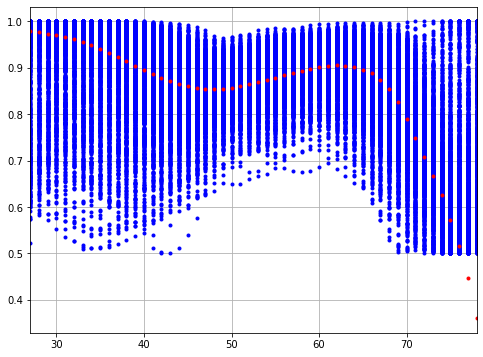

In [130]:
plt.figure(figsize=(8,6))
#plt.ylim(0.4,1)
plt.xlim(27,78)
for i in AUCs:
    plt.plot(age_grid, i, 'b.')
plt.plot(age_grid, auc_age_est_full_data2, 'r.')
plt.grid(visible=True)
plt.show()

#print(auc_age_est_full_data)

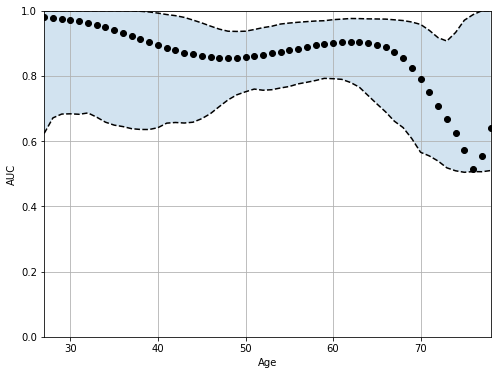

In [131]:
import scipy.stats as stats


AUCs = np.array(AUCs)

AUC975s = []
AUC25s = []
AUCs_now = []

for i in range(len(age_grid)):
    AUCs_at_age_i = AUCs[:,i]
    
    AUC975 = stats.mstats.mquantiles(AUCs_at_age_i, 0.975)
    AUC25 = stats.mstats.mquantiles(AUCs_at_age_i, 0.025)

    AUC975s.append(AUC975)
    AUC25s.append(AUC25)

AUC25s = [i[0] for i in AUC25s]
AUC975s = [i[0] for i in AUC975s]

plt.figure(figsize=(8,6))
plt.plot(age_grid, AUC975s, 'k--')
plt.plot(age_grid, AUC25s, 'k--')
plt.fill_between(age_grid, AUC25s, AUC975s, alpha=0.2)
plt.plot(age_grid, [i if i > 0.5 else 1-i for i in auc_age_est_full_data2], 'ko')
plt.grid(visible=True)
plt.xlim(27,78)
plt.xlabel('Age')
plt.ylabel('AUC')
plt.ylim(0,1)
plt.show()